## Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential, Model
import json
from datetime import datetime
from keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import Callback
import time
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

2025-04-12 00:06:16.705729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744416376.714871   21010 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744416376.719152   21010 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Enable GPU

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         tf.config.set_visible_devices(gpus[0], 'GPU')
#         print("Using GPU:", gpus[0])
#     except RuntimeError as e:
#         print(e)

## Load the Dataset

In [3]:
# Define image paths
clean_path = "../my_dataset/celeba_64x64_25000/clean"
noisy_path = "../my_dataset/celeba_64x64_25000/noisy"

# Load all image filenames
image_filenames = sorted(os.listdir(clean_path))

# Load images
clean_images = []
noisy_images = []

for fname in image_filenames:
    clean_img = Image.open(os.path.join(clean_path, fname)).convert('RGB')
    noisy_img = Image.open(os.path.join(noisy_path, fname)).convert('RGB')
    
    clean_images.append(np.array(clean_img))
    noisy_images.append(np.array(noisy_img))

# Convert lists to numpy arrays
clean_images = np.array(clean_images)
noisy_images = np.array(noisy_images)

# Split into training and testing sets
x_train_clean, x_test_clean, x_train_noisy, x_test_noisy = train_test_split(
    clean_images, noisy_images, test_size=0.1, random_state=42)

# Normalize pixel values to [0, 1]
x_train_clean = x_train_clean.astype('float32') / 255.
x_test_clean = x_test_clean.astype('float32') / 255.
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.

# Shuffle data while maintaining alignment
perm = np.random.permutation(len(x_train_clean))
x_train_clean = x_train_clean[perm]
x_train_noisy = x_train_noisy[perm]

perm_test = np.random.permutation(len(x_test_clean))
x_test_clean = x_test_clean[perm_test]
x_test_noisy = x_test_noisy[perm_test]


## Exploratory Data Analysis

### Dataset Size

In [4]:
print(f"Number of training images: {x_train_clean.shape[0]}")
print(f"Number of test images: {x_test_clean.shape[0]}")

Number of training images: 22500
Number of test images: 2500


### Distribution and Value Ranges

In [5]:
print("Image shape (train):", x_train_clean[0].shape)
print("Pixel value range (clean):", x_train_clean.min(), "to", x_train_clean.max())
print("Pixel value range (noisy):", x_train_noisy.min(), "to", x_train_noisy.max())

Image shape (train): (64, 64, 3)
Pixel value range (clean): 0.0 to 1.0
Pixel value range (noisy): 0.0 to 1.0


### Pixel Intensity Distributions

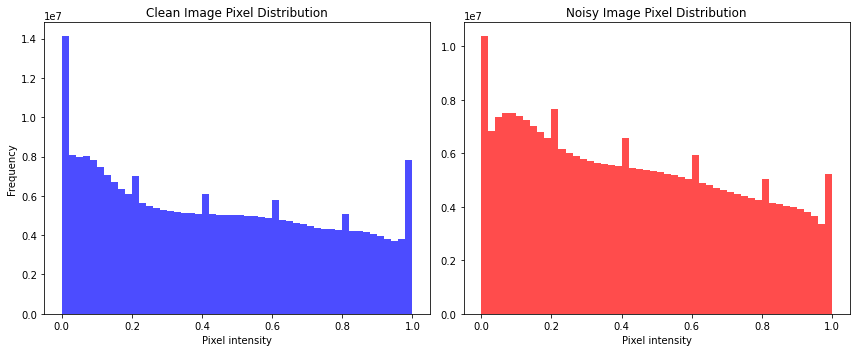

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x_train_clean.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Clean Image Pixel Distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(x_train_noisy.flatten(), bins=50, color='red', alpha=0.7)
plt.title("Noisy Image Pixel Distribution")
plt.xlabel("Pixel intensity")

plt.tight_layout()
plt.show()

### Visualize Images

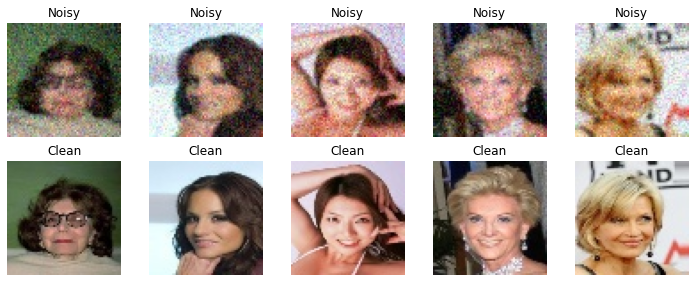

In [7]:
def show_samples(clean, noisy, num_samples=5):
    plt.figure(figsize=(num_samples * 2, 4))
    for i in range(num_samples):
        # Noisy
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')
        
        # Clean
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(x_train_clean, x_train_noisy)

## Model Creation

In [8]:
epochs = 2000
batch_size = 16
alpha = 0.84
loss_function = "ssim_mse"
model_name = f"UDnCNN_{loss_function}_a{alpha}_e{epochs}_b{batch_size}_v2"
print(model_name)

UDnCNN_ssim_mse_a0.84_e2000_b16_v2


### SSIM Loss function

In [9]:
def combined_loss_mae(y_true, y_pred, alpha=alpha):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return alpha * mae + (1 - alpha) * (1 - ssim)

def combined_loss_mse(y_true, y_pred, alpha=alpha):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return alpha * mse + (1 - alpha) * (1 - ssim)

In [10]:
input_img = Input(shape=(x_train_clean.shape[1], x_train_clean.shape[2], x_train_clean.shape[3]))

# Initial Conv + ReLU
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

# Downsampling block 1
x1 = Conv2D(64, (3, 3), padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
p1 = MaxPooling2D(pool_size=(2, 2))(x1)

# Downsampling block 2
x2 = Conv2D(64, (3, 3), padding='same')(p1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
p2 = MaxPooling2D(pool_size=(2, 2))(x2)

# Middle block 1
x3 = Conv2D(64, (3, 3), padding='same')(p2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)

# Middle block 2
x4 = Conv2D(64, (3, 3), padding='same')(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)

# Upsampling block 1 + skip connection with x2
u1 = UpSampling2D(size=(2, 2))(x4)
u1 = Add()([u1, x2])
u1 = Conv2D(64, (3, 3), padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = ReLU()(u1)

# Upsampling block 2 + skip connection with x1
u2 = UpSampling2D(size=(2, 2))(u1)
u2 = Add()([u2, x1])
u2 = Conv2D(64, (3, 3), padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = ReLU()(u2)

# Final output layer
output = Conv2D(3, (3, 3), padding='same')(u2)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, output])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss=combined_loss_mse)
# model.summary()

I0000 00:00:1744416495.046753   21010 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 94412 MB memory:  -> device: 0, name: NVIDIA GH200 480GB, pci bus id: 0000:dd:00.0, compute capability: 9.0


## Train the model

### Callback to Track Time

In [11]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()  # returns float in seconds

    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.start_time

time_callback = TimeHistory()

### Train

In [ ]:
history = model.fit(
    x_train_noisy, x_train_clean,
    validation_data=(x_test_noisy, x_test_clean),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[time_callback]
)
print("Training time (seconds):", round(time_callback.total_time, 2))

Epoch 1/2000


I0000 00:00:1744416505.486654   21388 service.cc:148] XLA service 0xe986f801dbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744416505.486682   21388 service.cc:156]   StreamExecutor device (0): NVIDIA GH200 480GB, Compute Capability 9.0
2025-04-12 00:08:25.568095: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1744416505.706553   21388 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert/Assert
W0000 00:00:1744416505.706663   21388 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_1/Assert
W0000 00:00:1744416505.707042   21388 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_2/Assert
W0000 00:00:1744416505.707114   21388 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_3/A

  77/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2061

I0000 00:00:1744416507.870297   21388 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0608

W0000 00:00:1744416510.905851   21386 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert/Assert
W0000 00:00:1744416510.905890   21386 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_1/Assert
W0000 00:00:1744416510.905939   21386 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_2/Assert
W0000 00:00:1744416510.905948   21386 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_3/Assert


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0608

W0000 00:00:1744416513.277029   21386 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert/Assert
W0000 00:00:1744416513.277105   21386 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_1/Assert
W0000 00:00:1744416513.277516   21386 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_2/Assert
W0000 00:00:1744416513.277594   21386 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_3/Assert
W0000 00:00:1744416513.773556   21387 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert/Assert
W0000 00:00:1744416513.773624   21387 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_1/Assert
W0000 00:00:1744416513.773671   21387 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_2/Assert
W0000 00:00:1744416513.773680   21387 assert_op.cc:38] Ignoring Assert operator 

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0607 - val_loss: 0.0378
Epoch 2/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0337 - val_loss: 0.0365
Epoch 3/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0324 - val_loss: 0.0404
Epoch 4/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0303 - val_loss: 0.0298
Epoch 5/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0289 - val_loss: 0.0282
Epoch 6/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0280 - val_loss: 0.0290
Epoch 7/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0273 - val_loss: 0.0274
Epoch 8/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0268 - val_loss: 0.0276
Epoch 9/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0265 - val_loss: 0.0288
Epoch 10/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0261 - val_loss: 0.0268
Epoch 11/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0258 - val_loss: 0.0271
Epoch 12/2000
1407/1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0238 - val_loss: 0.0248
Epoch 198/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0237 - val_loss: 0.0247
Epoch 199/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0239 - val_loss: 0.0247
Epoch 200/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0238 - val_loss: 0.0247
Epoch 201/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0238 - val_loss: 0.0248
Epoch 202/2000
 902/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0238

### Save

In [ ]:
model_dir = f"./models/{model_name}"
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, "model.keras"))
print(f"\n✅ Model saved to: {model_dir}")

## Evaluate the Model

### Predict

In [ ]:
predictions = model.predict(x_test_noisy)

### Evaluate

In [ ]:
mae = np.mean(np.abs(predictions - x_test_clean))
mse = np.mean((predictions - x_test_clean) ** 2)

psnr_total, ssim_total = 0, 0
for i in range(len(x_test_clean)):
    psnr_total += peak_signal_noise_ratio(x_test_clean[i], predictions[i], data_range=1.0)
    ssim_total += structural_similarity(x_test_clean[i], predictions[i], channel_axis=-1, data_range=1.0)

psnr_avg = psnr_total / len(x_test_clean)
ssim_avg = ssim_total / len(x_test_clean)

### Save Metadata

In [ ]:
metadata = {
    "model_name": model_name,
    "created_at": datetime.now().isoformat(),
    "loss_function": loss_function,
    "alpha": alpha,
    "epochs": int(epochs),
    "batch_size": int(batch_size),
    "training_time_seconds": round(float(time_callback.total_time), 2),
    "dataset_info": {
        "train_size": int(x_train_clean.shape[0]),
        "test_size": int(x_test_clean.shape[0]),
        "image_shape": list(map(int, x_train_clean.shape[1:]))
    },
    "evaluation_metrics": {
        "mae": round(float(mae), 6),
        "mse": round(float(mse), 6),
        "psnr_avg": round(float(psnr_avg), 3),
        "ssim_avg": round(float(ssim_avg), 3)
    }
}
with open(os.path.join(model_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print(f"\n✅ Metadata saved to: {model_dir}")

### Visualize the Results

In [ ]:
def show_predictions(noisy, clean, predicted, num_images=5):
    plt.figure(figsize=(num_images * 3, 9))
    for i in range(num_images):
        # Noisy
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Predicted
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Clean
        plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(x_test_noisy, x_test_clean, predictions)

In [ ]:
def visualize_and_save_denoising(noisy, predicted, clean, model_dir, num_images=5):
    """
    Visualize and save a comparison of noisy, denoised, and clean images.
    
    Args:
        noisy (numpy array): Noisy input images
        predicted (numpy array): Model predictions (denoised images)
        clean (numpy array): Ground truth clean images
        model_dir (str): Directory where the visualization image will be saved
        num_images (int): Number of image samples to visualize
    """
    plt.figure(figsize=(num_images * 3, 9))

    for i in range(num_images):
        # Noisy input
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Denoised (model output)
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Ground truth
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(model_dir, "denoising_visualization.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()  # Close the figure to free memory

    print(f"📸 Visualization saved to: {save_path}")

visualize_and_save_denoising(
    noisy=x_test_noisy,
    predicted=predictions,
    clean=x_test_clean,
    model_dir=model_dir,
    num_images=5  # You can increase this number if desired
)